In [38]:
import gymnasium as gym
from stable_baselines3 import PPO

# Create the CartPole-v1 environment
env = gym.make("CartPole-v1")

# Initialize the PPO agent with the environment
model = PPO("MlpPolicy", env, verbose=1)

# Train the model for some number of timesteps
model.learn(total_timesteps=10000)

# Save the trained model (optional)
model.save("ppo_cartpole")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 20.3     |
| time/              |          |
|    fps             | 1392     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.1        |
|    ep_rew_mean          | 28.1        |
| time/                   |             |
|    fps                  | 890         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009675419 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [141]:
def collect_expert_demos_with_fixed_steps(model, env, n_demos=100, max_steps=200):
    expert_demos = []
    count = 0
    while count < n_demos :
        obs, _ = env.reset()  # Reset environment and get initial state
        trajectory = []
        steps = 0
        done = False
        while not done and steps < max_steps:
            action, _states = model.predict(obs)  # Get action from expert policy
            next_obs, reward, done, truncated, info = env.step(action)  # Take step
            trajectory.append(obs)  # Store state-action-reward triplet
            obs = next_obs  # Update state for next step
            steps += 1  # Increment step counter
        if (len(trajectory) == max_steps):
            expert_demos.append(trajectory)  # Store the full trajectory
            count += 1
    return expert_demos

expert_demos = collect_expert_demos_with_fixed_steps(model, env, n_demos=10)


In [142]:
len(expert_demos[0][0])

4

In [143]:
from RBF_IRL import *

Selecting K using multi-armed bandit and expert data clustering quality...
Trial 1/5 for K=2, Silhouette Score: 0.3311
Trial 2/5 for K=3, Silhouette Score: 0.3552
Trial 3/5 for K=3, Silhouette Score: 0.3552
Trial 4/5 for K=2, Silhouette Score: 0.3311
Trial 5/5 for K=3, Silhouette Score: 0.3552

Selected K=3 (best silhouette score: 0.3552)
Computed 3 RBF centers with per_cluster kernel widths
Kernel widths range: 0.2058 to 0.3008
Mean width: 0.2595, Std dev: 0.0398

Starting IRL training...
Epoch 1/20, Feature Expectation Loss: 0.0885
Epoch 2/20, Feature Expectation Loss: 0.0630
Epoch 3/20, Feature Expectation Loss: 0.0812
Epoch 4/20, Feature Expectation Loss: 0.1186
Epoch 5/20, Feature Expectation Loss: 0.0719
Epoch 6/20, Feature Expectation Loss: 0.0556
Epoch 7/20, Feature Expectation Loss: 0.0677
Epoch 8/20, Feature Expectation Loss: 0.0646
Epoch 9/20, Feature Expectation Loss: 0.1119
Epoch 10/20, Feature Expectation Loss: 0.1087
Epoch 11/20, Feature Expectation Loss: 0.0526
Epoch 12

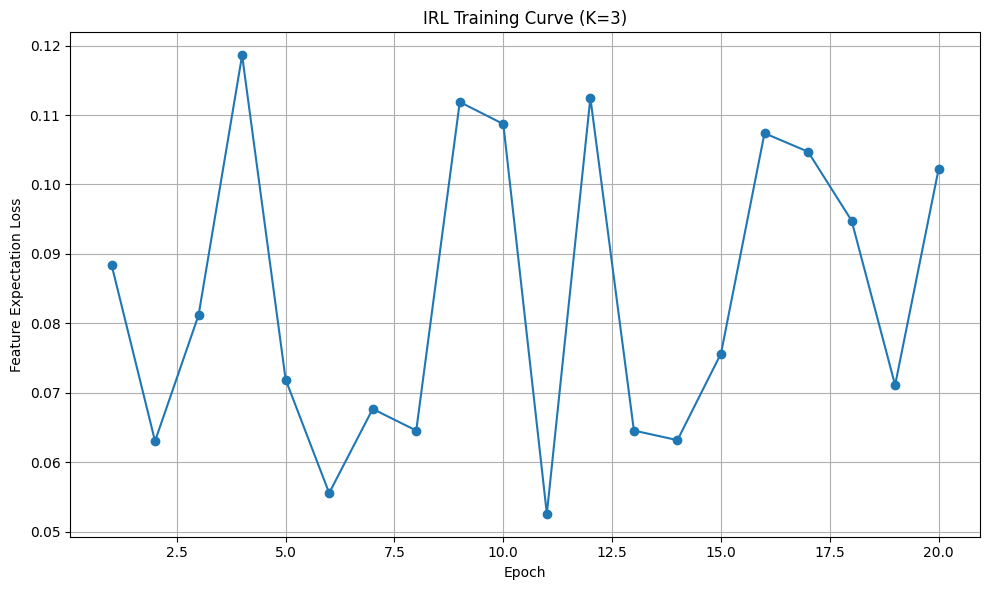

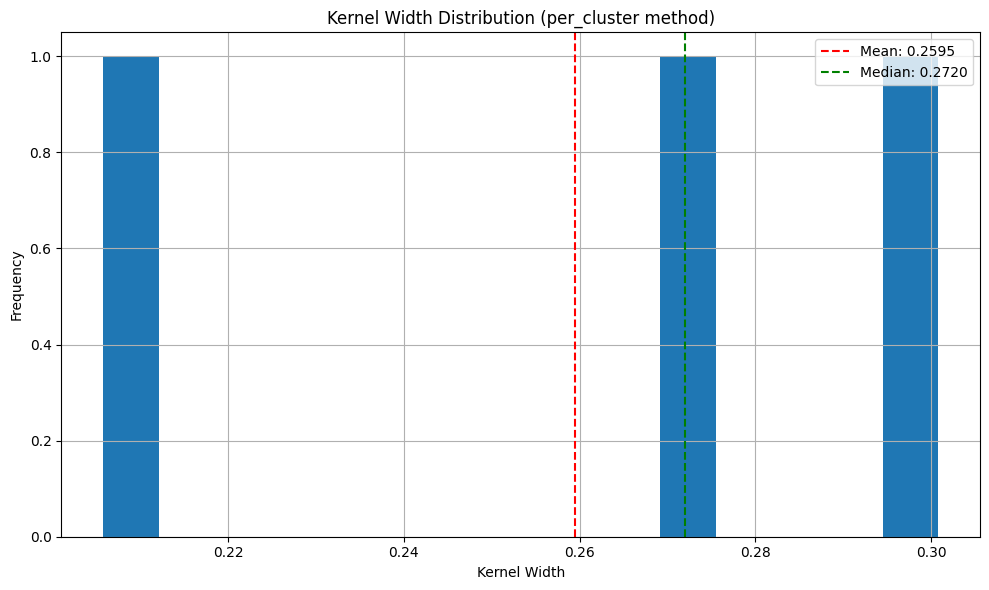

In [146]:

# Initialize RBF_IRL model with expert demos
irl = RBF_IRL(
    expert_demos=expert_demos,
    state_space_dim=4,
    n_rbf_centers=None,
    kernel_width_method="per_cluster",
    width_scale_factor=0.5,
    learning_rate=0.01,
    epochs=5,
    env_name="CartPole-v1",
    n_rollout_episodes=10,
    k_candidates=[2, 3],  # Candidate K values to try
    k_selection_trials = 5  # Number of bandit trials
)

# Train the model
losses = irl.train()

# Plot the training loss curve
irl.plot_training_curve(losses)

# Visualize kernel widths
irl.visualize_kernel_widths()


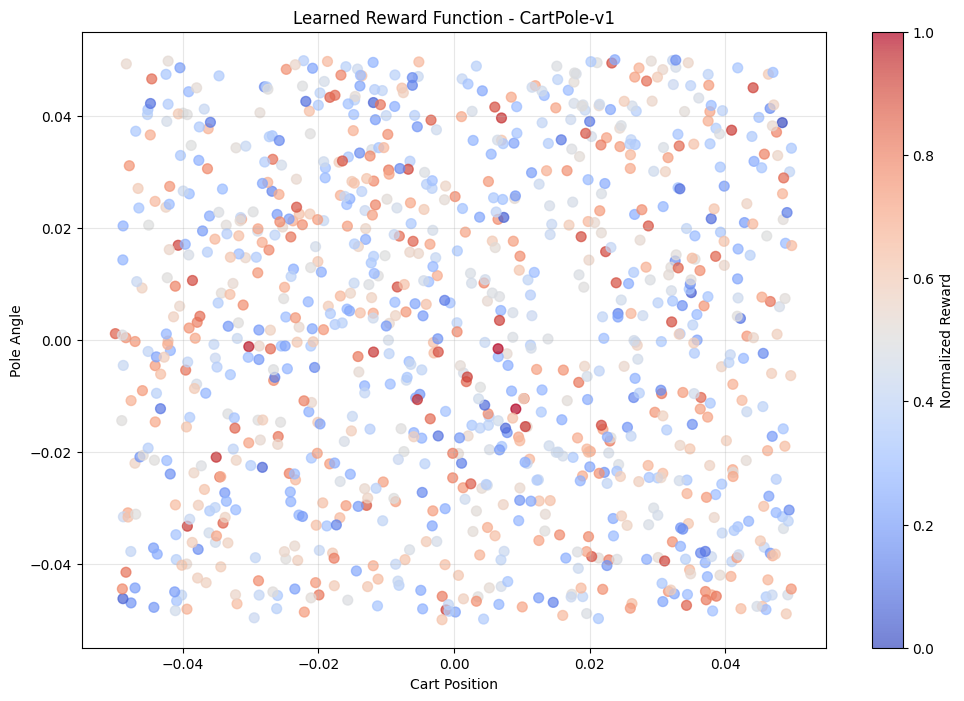

In [147]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_learned_reward_function(irl, env, n_samples=1000, title="Learned Reward Function"):
    """
    Visualize the learned reward function over the state space.

    Args:
        irl: Trained RBF IRL model.
        env: The environment (e.g., CartPole-v1).
        n_samples: Number of samples to collect for visualization.
        title: Title for the plot.
    """
    # Collect states
    states = []
    for _ in range(n_samples):
        obs, _ = env.reset()
        states.append(obs)

    states = np.array(states)

    # Compute rewards for each state
    rewards = np.array([irl.get_reward(state) for state in states])

    # Normalize rewards for better visualization
    min_reward, max_reward = np.min(rewards), np.max(rewards)
    if max_reward - min_reward != 0:
        rewards_normalized = (rewards - min_reward) / (max_reward - min_reward)
    else:
        rewards_normalized = np.zeros_like(rewards)  # Handle zero division case

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.scatter(states[:, 0], states[:, 2], c=rewards_normalized, cmap="coolwarm", s=50, alpha=0.7)
    plt.colorbar(label="Normalized Reward")
    plt.xlabel("Cart Position")
    plt.ylabel("Pole Angle")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:
visualize_learned_reward_function(irl, env, title="Learned Reward Function - CartPole-v1")


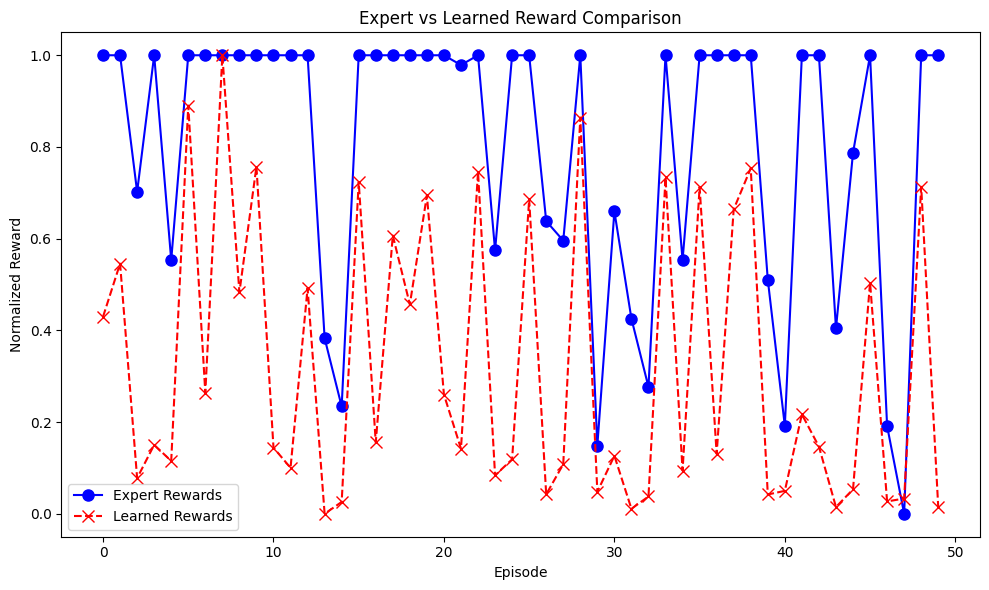

In [149]:
import numpy as np
import matplotlib.pyplot as plt

def collect_rewards_for_both(model, irl, env, n_episodes=10, max_steps=200):
    """Collects both expert and learned rewards for each episode."""
    expert_rewards = []
    learned_rewards = []
    
    for episode in range(n_episodes):
        obs, _ = env.reset()  # Reset environment
        total_expert_reward = 0
        total_learned_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            # Get expert action
            action, _ = model.predict(obs, deterministic=True)
            
            # Take step in environment (for expert rewards)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            total_expert_reward += reward
            
            # Get learned reward (using the learned model for the same state)
            learned_reward = irl.get_reward(obs.reshape(1, -1))  # Assuming irl.get_reward() expects a 2D array
            total_learned_reward += learned_reward
            
            # Move to the next state
            obs = next_obs
            done = terminated or truncated
            steps += 1
        
        # Store rewards for the current episode
        expert_rewards.append(total_expert_reward)
        learned_rewards.append(total_learned_reward)
    
    # Normalize the rewards
    expert_rewards_norm = normalize_rewards(expert_rewards)
    learned_rewards_norm = normalize_rewards(learned_rewards)
    
    return expert_rewards_norm, learned_rewards_norm

def normalize_rewards(rewards):
    """Normalize the rewards to the range [0, 1]."""
    min_reward = np.min(rewards)
    max_reward = np.max(rewards)
    
    # Avoid division by zero if all rewards are the same
    if max_reward > min_reward:
        return (rewards - min_reward) / (max_reward - min_reward)
    else:
        return np.full_like(rewards, 0.5)  # If all rewards are the same, return 0.5 for each

def plot_rewards(expert_rewards, learned_rewards, title="Expert vs Learned Reward Comparison"):
    """Plot both expert and learned rewards for multiple episodes."""
    episodes = np.arange(len(expert_rewards))  # Episode indices
    
    plt.figure(figsize=(10, 6))
    
    # Plot expert rewards
    plt.plot(episodes, expert_rewards, label="Expert Rewards", marker='o', color='b', linestyle='-', markersize=8)
    
    # Plot learned rewards
    plt.plot(episodes, learned_rewards, label="Learned Rewards", marker='x', color='r', linestyle='--', markersize=8)
    
    # Labels and title
    plt.xlabel("Episode")
    plt.ylabel("Normalized Reward")
    plt.title(title)
    
    # Add a legend
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example Usage:
expert_rewards, learned_rewards = collect_rewards_for_both(model, irl, env, n_episodes = 50)
plot_rewards(expert_rewards, learned_rewards)
